In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def df_preview(df):
    for col in df.columns:
        print(col, "null count ::", df[col].isnull().sum(), "// mean ::", df[col].mean())

def df_col_distplot(df):
    for col in df.columns:
        print(col, "plot")
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()

def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

In [4]:
## concat_df: train, test 를 합친 dataframe

concat_df = pd.concat([train, test])
concat_df.shape

(20000, 75)

In [5]:
## feature_df: target 을 제외한 dataframe

target_cols = ['hhb', 'hbo2', 'ca', 'na']
feature_df = concat_df.drop(target_cols, axis=1)

In [6]:
## KNNImputer 를 사용함
## n_neighbors = 2

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

In [7]:
imputed_df = imputer.fit_transform(feature_df)

In [8]:
## impute 결과가 list 로 나오기 때문에 dataframe 으로 바꿔주는 작업
imputed_df = pd.DataFrame(imputed_df, columns=feature_df.columns, index=list(feature_df.index.values))

In [9]:
std_scaler = StandardScaler()
std_scaler.fit(imputed_df)
std_scaled_feature = std_scaler.transform(imputed_df)
std_scaled_feature = pd.DataFrame(std_scaled_feature, columns=imputed_df.columns, index=list(imputed_df.index.values))

In [10]:
imputed_df.head()

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,2.902866e-19,3.527371e-18,1.933918e-18,6.455564e-19,1.007089e-18,0.000000e+00,3.821327e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,2.647633e-09,2.097907e-10,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,1.017827e-10,9.710091e-09,1.482400e-09
2,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,1.909213e-18
3,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,1.274876e-10,6.118947e-11,7.085245e-11,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,3.070868e-11,4.088921e-10,1.836648e-10
4,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,0.000000e+00,2.474000e-12,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,1.464461e-12,1.330237e-13,1.231381e-11,6.670449e-11


In [11]:
std_scaled_feature.head()

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,1.332257,0.733433,0.786592,0.951760,0.963029,1.133476,1.207972,1.298452,1.453511,1.435435,...,-0.223527,-0.217582,-0.218477,-0.217927,-0.204818,-0.192773,-0.157738,-0.180670,-0.227792,-0.236679
1,-1.343585,-0.662554,-0.707615,-0.693873,-0.800497,-0.850550,-0.848762,-0.951857,-1.019855,-1.083122,...,7.356306,0.467903,16.757105,33.001779,37.112763,27.225249,13.094129,0.235598,18.411056,1.213401
2,1.332257,-0.662554,-0.593307,-0.674131,-0.689131,-0.679612,-0.651741,-0.556629,-0.529055,-0.414247,...,-0.223527,-0.217582,-0.218477,-0.217927,-0.204818,-0.192773,-0.157738,-0.180670,-0.227792,-0.236679
3,-1.343585,0.349141,0.379545,0.323864,0.465586,0.512360,0.572584,0.779221,0.923532,1.004891,...,0.141453,-0.017647,0.011344,0.219284,0.419211,0.390113,0.326337,-0.055078,0.557090,-0.057018
4,-0.451638,3.071887,2.798157,2.485780,2.249688,2.126834,1.939869,1.742492,1.574877,1.572196,...,-0.223527,-0.209499,-0.218427,-0.217795,-0.204412,-0.192380,-0.148629,-0.180126,-0.204155,-0.171429


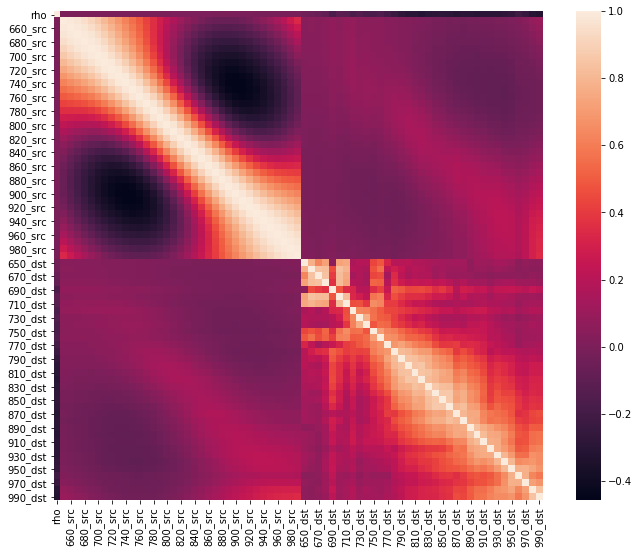

In [12]:
corrmat = std_scaled_feature.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True)

In [13]:
std_scaled_feature.describe()

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,...,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,-1.666972e-16,5.272727e-17,4.630740e-17,1.425610e-16,2.498002e-19,6.525058e-17,8.537893e-17,5.442868e-17,3.595457e-17,7.129297e-17,...,-6.774026e-17,-7.776141e-17,1.423278e-16,-5.554862e-17,-6.885187e-17,-3.947537e-17,-3.745088e-16,-3.599621e-17,-4.183043e-17,-9.443973e-17
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-1.343585e+00,-6.625540e-01,-7.076154e-01,-7.532315e-01,-8.004971e-01,-8.505498e-01,-9.039989e-01,-9.605332e-01,-1.019855e+00,-1.083122e+00,...,-2.235274e-01,-2.175824e-01,-2.184768e-01,-2.179267e-01,-2.048175e-01,-1.927733e-01,-1.577375e-01,-1.806699e-01,-2.277917e-01,-2.366788e-01
25%,-4.516377e-01,-6.352320e-01,-6.741553e-01,-7.151626e-01,-7.587581e-01,-8.028127e-01,-8.502524e-01,-8.896392e-01,-9.225959e-01,-9.511064e-01,...,-2.235274e-01,-2.175824e-01,-2.184768e-01,-2.179267e-01,-2.048175e-01,-1.927733e-01,-1.577375e-01,-1.806699e-01,-2.277917e-01,-2.366787e-01
50%,4.403099e-01,-4.685688e-01,-4.807717e-01,-4.916517e-01,-4.987455e-01,-4.964163e-01,-4.844226e-01,-4.602753e-01,-4.265120e-01,-3.638144e-01,...,-2.235233e-01,-2.175793e-01,-2.184743e-01,-2.179222e-01,-2.048145e-01,-1.927724e-01,-1.577372e-01,-1.806688e-01,-2.277818e-01,-2.366550e-01
75%,1.332257e+00,1.588622e-01,2.581211e-01,3.623008e-01,4.966430e-01,6.466261e-01,7.929425e-01,9.282114e-01,1.046166e+00,1.105435e+00,...,-2.193751e-01,-2.135861e-01,-2.147129e-01,-2.138969e-01,-2.014633e-01,-1.907445e-01,-1.566472e-01,-1.787634e-01,-2.219333e-01,-2.288111e-01
max,1.332257e+00,3.089470e+00,2.837256e+00,2.586064e+00,2.345784e+00,2.133475e+00,1.950083e+00,1.796304e+00,1.674659e+00,1.583568e+00,...,3.320093e+01,3.948333e+01,4.158744e+01,3.658581e+01,4.096116e+01,2.892743e+01,3.575535e+01,3.733853e+01,2.645946e+01,2.600140e+01


In [14]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']

for col_name in target_cols:
    std_scaled_feature[col_name] = concat_df[col_name]

In [15]:
std_scaled_feature

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,1.332257,0.733433,0.786592,0.951760,0.963029,1.133476,1.207972,1.298452,1.453511,1.435435,...,-0.204818,-0.192773,-0.157738,-0.180670,-0.227792,-0.236679,5.59,4.32,8.92,4.29
1,-1.343585,-0.662554,-0.707615,-0.693873,-0.800497,-0.850550,-0.848762,-0.951857,-1.019855,-1.083122,...,37.112763,27.225249,13.094129,0.235598,18.411056,1.213401,0.00,2.83,7.25,4.64
2,1.332257,-0.662554,-0.593307,-0.674131,-0.689131,-0.679612,-0.651741,-0.556629,-0.529055,-0.414247,...,-0.204818,-0.192773,-0.157738,-0.180670,-0.227792,-0.236679,10.64,3.00,8.40,5.16
3,-1.343585,0.349141,0.379545,0.323864,0.465586,0.512360,0.572584,0.779221,0.923532,1.004891,...,0.419211,0.390113,0.326337,-0.055078,0.557090,-0.057018,5.67,4.01,5.05,4.35
4,-0.451638,3.071887,2.798157,2.485780,2.249688,2.126834,1.939869,1.742492,1.574877,1.572196,...,-0.204412,-0.192380,-0.148629,-0.180126,-0.204155,-0.171429,11.97,4.41,10.78,2.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.451638,-0.503128,-0.593655,-0.561602,-0.674941,-0.625168,-0.684088,-0.793826,-0.784652,-0.852190,...,-0.202614,-0.192773,-0.157738,-0.180068,-0.224951,-0.231405,NaN,NaN,NaN,NaN
19996,1.332257,-0.661818,-0.637793,-0.696722,-0.682777,-0.607732,-0.661087,-0.547008,-0.541709,-0.445803,...,-0.204817,-0.192773,-0.157738,-0.180670,-0.227792,-0.236679,NaN,NaN,NaN,NaN
19997,-0.451638,-0.662554,-0.707615,-0.749303,-0.800497,-0.723378,-0.487571,0.144445,1.103256,1.562130,...,-0.204796,-0.192692,-0.157730,-0.180664,-0.227792,-0.236508,NaN,NaN,NaN,NaN
19998,0.440310,-0.353929,-0.509861,-0.480078,-0.420311,-0.478424,-0.435804,-0.470005,-0.391996,-0.262009,...,-0.204817,-0.192773,-0.157738,-0.180670,-0.227792,-0.236679,NaN,NaN,NaN,NaN


In [16]:
## KNN impute 사용 lightgbm 사용
## submission 제출 결과 : 1.32443

from xgboost import XGBRegressor

target_col_list = ['hhb', 'hbo2', 'ca', 'na']
feature_col = std_scaled_feature.columns.drop(target_col_list)

scaled_train = std_scaled_feature[std_scaled_feature['hhb'].notnull()]
scaled_test = std_scaled_feature[std_scaled_feature['hhb'].isnull()]

x_data = scaled_train[feature_col]
y_data = scaled_train['hhb']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
eval_set = [(x_val, y_val)]

# xgbr = XGBRegressor(learning_rate=0.05, max_depth=7, n_estimators=2000)
# xgbr = XGBRegressor(booster="dart", n_estimators=2000) # 1.69568
# xgbr = XGBRegressor(booster="gbtree", n_estimators=2000) # 1.69568
# xgbr = XGBRegressor(learning_rate=0.05, booster="dart", n_estimators=2000) # 1.58725
# xgbr = XGBRegressor(learning_rate=0.05, n_estimators=2000) # 1.58645
# xgbr = XGBRegressor(learning_rate=0.05, max_depth=4, n_estimators=2000) # 1.59063-1043
# xgbr = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=2000) # 1.59194-697
# xgbr = XGBRegressor(learning_rate=0.05, max_depth=6, n_estimators=2000) # 1.58645-748
# xgbr = XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=2000) # 1.59257-323
# xgbr = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=2000) # 1.61944-875


# xgbr = XGBRegressor(learning_rate=0.05, booster="dart", n_estimators=2000)
# xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=200, verbose=True)

In [17]:
xgbr = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=2000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=True)

4275
[353]	validation_0-rmse:1.64245
[354]	validation_0-rmse:1.64231
[355]	validation_0-rmse:1.64285
[356]	validation_0-rmse:1.64291
[357]	validation_0-rmse:1.64266
[358]	validation_0-rmse:1.64208
[359]	validation_0-rmse:1.64219
[360]	validation_0-rmse:1.64128
[361]	validation_0-rmse:1.64145
[362]	validation_0-rmse:1.64158
[363]	validation_0-rmse:1.64169
[364]	validation_0-rmse:1.64153
[365]	validation_0-rmse:1.64069
[366]	validation_0-rmse:1.64104
[367]	validation_0-rmse:1.64086
[368]	validation_0-rmse:1.64102
[369]	validation_0-rmse:1.64078
[370]	validation_0-rmse:1.64024
[371]	validation_0-rmse:1.63976
[372]	validation_0-rmse:1.63910
[373]	validation_0-rmse:1.63938
[374]	validation_0-rmse:1.63956
[375]	validation_0-rmse:1.63972
[376]	validation_0-rmse:1.63953
[377]	validation_0-rmse:1.63953
[378]	validation_0-rmse:1.63961
[379]	validation_0-rmse:1.63964
[380]	validation_0-rmse:1.63991
[381]	validation_0-rmse:1.64077
[382]	validation_0-rmse:1.64069
[383]	validation_0-rmse:1.64091
[38

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [18]:
from sklearn.model_selection import validation_curve

model = XGBRegressor()
param_range = [2,3,4,5,6,7]

train_scores, test_scores = validation_curve(model, x_train, y_train, param_name="max_depth", param_range=param_range, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

[-1.61497193 -1.32681243 -1.04055111 -0.75141955 -0.4860601  -0.26795883]
[-1.79816089 -1.71000639 -1.68990828 -1.72633285 -1.73452812 -1.73738571]


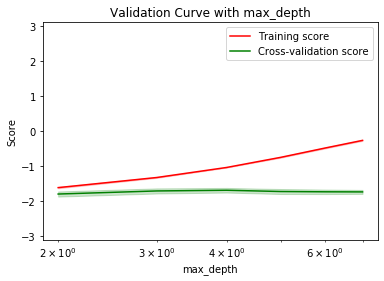

In [19]:
train_scores_mean = np.mean(train_scores, axis=1)
print(train_scores_mean)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
print(test_scores_mean)
test_scores_std = np.std(test_scores, axis=1)

plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")

plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.title("Validation Curve with max_depth")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(-3.1, 3.1)
plt.show()

# max_depth 2일때가 좋음
param_range = [2,3,4,5,6,7]

In [20]:
param_name = 'learning_rate'
param_range = [0.2, 0.1, 0.05, 0.01]

train_scores, test_scores = validation_curve(model, x_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

[-0.64422015 -0.93178728 -1.21320803 -3.5334598 ]
[-1.6828595  -1.66182266 -1.7091507  -3.61812351]


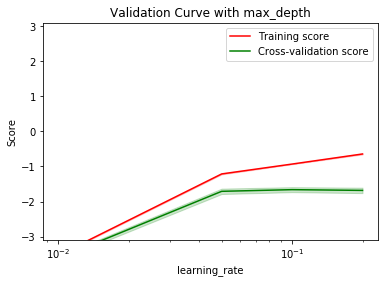

In [21]:
train_scores_mean = np.mean(train_scores, axis=1)
print(train_scores_mean)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
print(test_scores_mean)
test_scores_std = np.std(test_scores, axis=1)

plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")

plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.title("Validation Curve with max_depth")
plt.xlabel("learning_rate")
plt.ylabel("Score")
plt.ylim(-3.1, 3.1)
plt.show()

# 0.05 일때가 최적

In [22]:
xgbr = XGBRegressor(learning_rate=0.05, max_depth=2, n_estimators=4000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=True)

1.64741
[1930]	validation_0-rmse:1.64745
[1931]	validation_0-rmse:1.64728
[1932]	validation_0-rmse:1.64726
[1933]	validation_0-rmse:1.64721
[1934]	validation_0-rmse:1.64713
[1935]	validation_0-rmse:1.64710
[1936]	validation_0-rmse:1.64706
[1937]	validation_0-rmse:1.64703
[1938]	validation_0-rmse:1.64712
[1939]	validation_0-rmse:1.64718
[1940]	validation_0-rmse:1.64723
[1941]	validation_0-rmse:1.64724
[1942]	validation_0-rmse:1.64716
[1943]	validation_0-rmse:1.64719
[1944]	validation_0-rmse:1.64722
[1945]	validation_0-rmse:1.64725
[1946]	validation_0-rmse:1.64723
[1947]	validation_0-rmse:1.64730
[1948]	validation_0-rmse:1.64737
[1949]	validation_0-rmse:1.64735
[1950]	validation_0-rmse:1.64735
[1951]	validation_0-rmse:1.64725
[1952]	validation_0-rmse:1.64727
[1953]	validation_0-rmse:1.64732
[1954]	validation_0-rmse:1.64730
[1955]	validation_0-rmse:1.64732
[1956]	validation_0-rmse:1.64724
[1957]	validation_0-rmse:1.64712
[1958]	validation_0-rmse:1.64711
[1959]	validation_0-rmse:1.64699
[1

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=4000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [23]:
from sklearn.model_selection import KFold

folds = KFold(n_splits = 5, shuffle = True, random_state = 551)

In [24]:
## kfold, xgboost, scaled
## 결과값 1.3612979206

# xgbr = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=4000)
# target_col ::  hhb
# valid rmse ::  1.600307058154723
# valid rmse ::  1.6169826168656098
# valid rmse ::  1.6048208062982932
# valid rmse ::  1.5655431975982417

# xgbr = XGBRegressor(learning_rate=0.05, max_depth=7, n_estimators=4000)
# xgbr.fit(train_X, train_y, eval_set=eval_set, early_stopping_rounds=100, verbose=False)
# target_col ::  hhb
# valid rmse ::  1.5906712400520866 # valid rmse ::  1.6112062191602634 # valid rmse ::  1.5768733558078973 # valid rmse ::  1.5538987304907372 # valid rmse ::  1.629986665755717
# target_col ::  hbo2
# valid rmse ::  0.8690771650653575 # valid rmse ::  0.8764845430169661 # valid rmse ::  0.8755286219873124 # valid rmse ::  0.8555537464226269 # valid rmse ::  0.8757578387922907
# target_col ::  ca
# valid rmse ::  2.6079318673686793 # valid rmse ::  2.6348053233419026 # valid rmse ::  2.644520538255243 # valid rmse ::  2.6376416346811897 # valid rmse ::  2.5404489140920004
# target_col ::  na
# valid rmse ::  1.7367060120251887 # valid rmse ::  1.7440174470056022 # valid rmse ::  1.734155950960418 # valid rmse ::  1.693165725516102 # valid rmse ::  1.70920094128348


# xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
# xgbr.fit(train_X, train_y, eval_set=eval_set, early_stopping_rounds=100, verbose=False)
# target_col ::  hhb
# valid rmse ::  1.5675833386932783 # valid rmse ::  1.5984951957286488 # valid rmse ::  1.5752626238504617 # valid rmse ::  1.548948114061912 # valid rmse ::  1.6163373336455384
# target_col ::  hbo2
# valid rmse ::  0.8712967491094402 # valid rmse ::  0.8804659699729813 # valid rmse ::  0.8768960720388759 # valid rmse ::  0.8546141682914027 # valid rmse ::  0.8726454669568671
# target_col ::  ca
# valid rmse ::  2.5992696408471345 # valid rmse ::  2.645150242144852 # valid rmse ::  2.6585408469598475 # valid rmse ::  2.626926719272823 # valid rmse ::  2.5368726638544947
# target_col ::  na
# valid rmse ::  1.7309691785357686 # valid rmse ::  1.741186796049786 # valid rmse ::  1.7281665130875439 # valid rmse ::  1.6925965155785818 # valid rmse ::  1.700301534542143

target_col_list = ['hhb', 'hbo2', 'ca', 'na']
feature_col = std_scaled_feature.columns.drop(target_col_list)
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

scaled_train = std_scaled_feature[std_scaled_feature['hhb'].notnull()]
scaled_test = std_scaled_feature[std_scaled_feature['hhb'].isnull()]

# x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
# eval_set = [(x_val, y_val)]

for target_col in target_col_list:
    print("target_col :: ",target_col)
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(scaled_train)):
        x_data = scaled_train[feature_col]
        y_data = scaled_train[target_col]

        train_X, train_y = x_data.iloc[trn_idx], y_data.iloc[trn_idx] 
        valid_X, valid_y = x_data.iloc[val_idx], y_data.iloc[val_idx]

        eval_set = [(valid_X, valid_y)]

        xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
        xgbr.fit(train_X, train_y, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

        x_pred = xgbr.predict(valid_X)
        print("valid rmse :: ", rmse(x_pred, valid_y))

        test_x = scaled_test[feature_col]
        test_pred = xgbr.predict(test_x)
        submission[target_col] = submission[target_col] + test_pred

target_col ::  hhb
valid rmse ::  1.5675833386932783
valid rmse ::  1.5984951957286488


KeyboardInterrupt: 

In [78]:
submission

,hhb,hbo2,ca,na
id,,,,
10000,40.156975,21.607046,47.269734,18.154529
10001,32.926273,17.184997,38.636508,16.003959
10002,51.631516,23.260752,50.719757,16.332745
10003,45.183736,20.818978,52.140843,15.915744
10004,30.446937,19.145748,42.972045,18.433082
...,...,...,...,...
19995,24.292035,19.325900,57.483046,18.695906
19996,46.726851,17.646476,41.561291,14.655868
19997,43.606779,19.093000,40.296094,17.152793


In [79]:
submission = submission / 5
submission

,hhb,hbo2,ca,na
id,,,,
10000,8.031395,4.321409,9.453947,3.630906
10001,6.585255,3.436999,7.727302,3.200792
10002,10.326303,4.652150,10.143951,3.266549
10003,9.036747,4.163796,10.428169,3.183149
10004,6.089387,3.829150,8.594409,3.686616
...,...,...,...,...
19995,4.858407,3.865180,11.496609,3.739181
19996,9.345370,3.529295,8.312258,2.931174
19997,8.721356,3.818600,8.059219,3.430559


In [72]:
target_col_list = ['hhb', 'hbo2', 'ca', 'na']
feature_col = std_scaled_feature.columns.drop(target_col_list)
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

scaled_train = std_scaled_feature[std_scaled_feature['hhb'].notnull()]
scaled_test = std_scaled_feature[std_scaled_feature['hhb'].isnull()]

# x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
# eval_set = [(x_val, y_val)]

for target_col in target_col_list:
    print("target_col :: ",target_col)
    x_data = scaled_train[feature_col]
    y_data = scaled_train[target_col]

    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
    eval_set = [(x_val, y_val)]

    xgbr = XGBRegressor(learning_rate=0.05, max_depth=2, n_estimators=4000)
    xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

    x_pred = xgbr.predict(x_val)
    print("valid rmse :: ", rmse(x_pred, y_val))

    test_x = scaled_test[feature_col]
    test_pred = xgbr.predict(test_x)

    submission[target_col] = test_pred

target_col ::  hhb
valid rmse ::  1.641063317844755
target_col ::  hbo2
valid rmse ::  0.8882807230797396
target_col ::  ca
valid rmse ::  2.622388352808981
target_col ::  na
valid rmse ::  1.7417833148260606


In [26]:
import eli5
from eli5.sklearn import PermutationImportance

target_col_list = ['hhb', 'hbo2', 'ca', 'na']
feature_col = std_scaled_feature.columns.drop(target_col_list)

x_data = scaled_train[feature_col]
# y_data = scaled_train[target_col]
y_data = scaled_train['hhb']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
eval_set = [(x_val, y_val)]

xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

perm = PermutationImportance(xgbr, random_state=0).fit(x_data, y_data)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feature_col).sort_values(ascending=False)
eli5.show_weights(perm)

Weight,Feature
4.4500 ± 0.0401,x0
0.2205 ± 0.0037,x50
0.1457 ± 0.0042,x49
0.0970 ± 0.0020,x51
0.0852 ± 0.0021,x48
0.0834 ± 0.0022,x52
0.0652 ± 0.0011,x53
0.0375 ± 0.0007,x17
0.0332 ± 0.0018,x70
0.0242 ± 0.0009,x16


In [27]:
print(perm_feat_imp)

rho        4.450024
790_dst    0.220535
780_dst    0.145742
800_dst    0.096987
770_dst    0.085172
             ...   
670_dst    0.001985
690_src    0.001932
700_src    0.001895
680_src    0.001737
720_src    0.001696
Length: 71, dtype: float64


In [102]:
x_data = scaled_train[feature_col]
# y_data = scaled_train[target_col]
y_data = scaled_train['hhb']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
eval_set = [(x_val, y_val)]

xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

x_pred = xgbr.predict(x_val)
print("valid rmse :: ", rmse(x_pred, y_val))

valid rmse ::  1.5826603858854582


In [28]:
def evaluate(x_train, x_val, y_train, y_val):
    eval_set = [(x_val, y_val)]

    xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
    xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

    x_pred = xgbr.predict(x_val)
    score = rmse(x_pred, y_val)
    return score

In [34]:
# 10 1.684758869589525
# 13 1.6426071939276952
# 16 1.6288741604476555
# 19 1.5988935141644838
# 22 1.6010182454008894
# 25 1.5803393161338413
# 28 1.5577983295817588
# 31 1.551049878523078
# 34 1.556657594232173
# 37 1.551840199352926
# 40 1.5575562169309949
# 43 1.5628932492212875

# 28 1.5577983295817588
# 29 1.5590674430518063
# 30 1.559269160971409
# 31 1.551049878523078
# 32 1.549192754445179
# 33 1.562274627538096

# 32개 일 때 이상적

import eli5
from eli5.sklearn import PermutationImportance

target_col_list = ['hhb', 'hbo2', 'ca', 'na']
feature_col = std_scaled_feature.columns.drop(target_col_list)

x_data = scaled_train[feature_col]
# y_data = scaled_train[target_col]
y_data = scaled_train['hhb']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
eval_set = [(x_val, y_val)]

xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

perm = PermutationImportance(xgbr, random_state=0).fit(x_data, y_data)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feature_col).sort_values(ascending=False)
perm_feat_imp

hhb_best_col = perm_feat_imp.iloc[:32].index
print("hhb_best_col :: ", hhb_best_col)

x_data = scaled_train[feature_col]
y_data = scaled_train['hhb']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)

# for i in range(28, 34, 1):
#     print(i, evaluate(x_train[perm_feat_imp.iloc[:i].index], x_val[perm_feat_imp.iloc[:i].index], y_train, y_val))

hhb_best_col ::  Index(['rho', '790_dst', '780_dst', '800_dst', '770_dst', '810_dst', '820_dst',
       '810_src', '990_dst', '800_src', '830_dst', '840_dst', '990_src',
       '850_dst', '980_dst', '780_src', '970_src', '870_dst', '830_src',
       '880_dst', '790_src', '940_src', '760_dst', '980_src', '820_src',
       '860_dst', '970_dst', '840_src', '930_dst', '900_dst', '760_src',
       '940_dst'],
      dtype='object')


In [29]:
def permutation_loof(x_train, x_val, y_train, y_val, perm_feat_imp, start, end, step):
    for i in range(start, end, step):
        print(i, evaluate(x_train[perm_feat_imp.iloc[:i].index], x_val[perm_feat_imp.iloc[:i].index], y_train, y_val))



def get_perm_cols(model, feature_col, x_data, y_data):
    perm = PermutationImportance(model, random_state=0).fit(x_data, y_data)
    perm_feat_imp = pd.Series(perm.feature_importances_, index=feature_col).sort_values(ascending=False)
    return perm_feat_imp


In [30]:
target_col_list = ['hhb', 'hbo2', 'ca', 'na']


target_col = 'hbo2'

x_data = scaled_train[feature_col]
y_data = scaled_train[target_col]

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
eval_set = [(x_val, y_val)]

xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

x_pred = xgbr.predict(x_val)
print("all feature rmse :: ", rmse(x_pred, y_val))



all feature rmse ::  0.8854959407833528


In [31]:
hbo2_perm_imp = get_perm_cols(xgbr, feature_col, x_data, y_data)

In [125]:
# all feature rmse ::  0.8854959407833528
# 10 0.8767287384984064
# 13 0.8733047509709614
# 16 0.8808841095190516
# 19 0.8782288015190265
# 22 0.883130407177427
# 25 0.8848539677852677
# 28 0.8797514431105327
# 31 0.8832531163512344
# 34 0.8764850354556893
# 37 0.8782914272274931
# 40 0.878013079420498
# 43 0.8789441921472315
# 46 0.8752323636918761
# 49 0.8793716393583294
# 52 0.8839360007349716
# 55 0.8857112575107653
# 58 0.8847691611174118

# 10 0.8767287384984064
# 11 0.8754394480761193
# 12 0.8758274922704493
# 13 0.8733047509709614
# 14 0.8768277298359489
# 15 0.8802422304385066
# 16 0.8808841095190516

permutation_loof(x_train, x_val, y_train, y_val, hbo2_perm_imp, 10, 17, 1)

10 0.8767287384984064
11 0.8754394480761193
12 0.8758274922704493
13 0.8733047509709614
14 0.8768277298359489
15 0.8802422304385066
16 0.8808841095190516


In [35]:
hbo2_best_col = hbo2_perm_imp.iloc[:13].index

In [36]:
target_col = 'ca'

x_data = scaled_train[feature_col]
y_data = scaled_train[target_col]

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
eval_set = [(x_val, y_val)]

xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

x_pred = xgbr.predict(x_val)
print("all feature rmse :: ", rmse(x_pred, y_val))

all feature rmse ::  2.620063526912127


In [37]:
ca_perm_imp = get_perm_cols(xgbr, feature_col, x_data, y_data)

In [38]:
print(ca_perm_imp)

rho        0.696527
970_dst    0.235589
980_dst    0.221038
950_dst    0.166548
960_dst    0.138716
             ...   
840_src    0.004625
710_src    0.004312
780_dst    0.004301
860_dst    0.003755
720_src    0.003410
Length: 71, dtype: float64


In [135]:
permutation_loof(x_train, x_val, y_train, y_val, ca_perm_imp, 10, 71, 3)

10 2.607600114880119
13 2.6050817716061614
16 2.6102825639899208
19 2.604621953403832
22 2.5918835144431984
25 2.60022277306102
28 2.6103544439855404
31 2.6025136645008295
34 2.6111894650327843
37 2.5999350045364844
40 2.6146680058155103
43 2.6099644582184465
46 2.597883866927244


KeyboardInterrupt: 

In [136]:
# all feature rmse ::  2.620063526912127
# 10 2.607600114880119
# 13 2.6050817716061614
# 16 2.6102825639899208
# 19 2.604621953403832
# 22 2.5918835144431984
# 25 2.60022277306102
# 28 2.6103544439855404
# 31 2.6025136645008295
# 34 2.6111894650327843
# 37 2.5999350045364844
# 40 2.6146680058155103
# 43 2.6099644582184465
# 46 2.597883866927244

# 19 2.604621953403832
# 20 2.60607537568137
# 21 2.5920747779611024
# 22 2.5918835144431984
# 23 2.5916488766306296
# 24 2.598460718353958
# 25 2.60022277306102

# 23 개

permutation_loof(x_train, x_val, y_train, y_val, ca_perm_imp, 19, 26, 1)

19 2.604621953403832
20 2.60607537568137
21 2.5920747779611024
22 2.5918835144431984
23 2.5916488766306296
24 2.598460718353958
25 2.60022277306102


In [39]:
ca_best_col = ca_perm_imp.iloc[:13].index

In [41]:
target_col = 'na'

x_data = scaled_train[feature_col]
y_data = scaled_train[target_col]

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
eval_set = [(x_val, y_val)]

xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
xgbr.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

x_pred = xgbr.predict(x_val)
print("all feature rmse :: ", rmse(x_pred, y_val))

all feature rmse ::  1.7246794328497708


In [42]:
na_perm_imp = get_perm_cols(xgbr, feature_col, x_data, y_data)

In [45]:
# all feature rmse ::  1.7246794328497708
# 10 1.764575081284667
# 13 1.7229311420890048
# 16 1.7235318207711874
# 19 1.7156857205239489
# 22 1.7208237395962585
# 25 1.7248833182992718
# 28 1.7228036487980818
# 31 1.7250693149985155
# 34 1.7178814523706154
# 37 1.7210521465814457
# 40 1.7211115336525966
# 43 1.7270109971889582
# 46 1.7262426323945206
# 49 1.7216740033996505
# 52 1.724795784080812
# 55 1.7230647201876712
# 58 1.7269491119629847
# 61 1.730581629009951
# 64 1.7276722564944271
# 67 1.7308081506085864
# 70 1.7235955874177944

# 31 1.7250693149985155
# 32 1.7202986151327666
# 33 1.7238490008912852
# 34 1.7178814523706154
# 35 1.7281990270535272
# 36 1.7217438713236246
# 37 1.7210521465814457

# 16 1.7235318207711874
# 17 1.7233466288390953
# 18 1.7189580823548134
# 19 1.7156857205239489
# 20 1.7284484888114888
# 21 1.7185241312954218
# 22 1.7208237395962585

# 19 일때가 이상적

permutation_loof(x_train, x_val, y_train, y_val, na_perm_imp, 16, 23, 1)

16 1.7235318207711874
17 1.7233466288390953
18 1.7189580823548134
19 1.7156857205239489
20 1.7284484888114888
21 1.7185241312954218
22 1.7208237395962585


In [46]:
na_best_col = ca_perm_imp.iloc[:19].index

In [47]:
print(hhb_best_col)
print(hbo2_best_col)
print(ca_best_col)
print(na_best_col)

Index(['rho', '790_dst', '780_dst', '800_dst', '770_dst', '810_dst', '820_dst',
       '810_src', '990_dst', '800_src', '830_dst', '840_dst', '990_src',
       '850_dst', '980_dst', '780_src', '970_src', '870_dst', '830_src',
       '880_dst', '790_src', '940_src', '760_dst', '980_src', '820_src',
       '860_dst', '970_dst', '840_src', '930_dst', '900_dst', '760_src',
       '940_dst'],
      dtype='object')
Index(['rho', '990_dst', '990_src', '790_dst', '780_dst', '980_dst', '980_src',
       '770_dst', '710_dst', '680_dst', '690_dst', '800_dst', '860_dst'],
      dtype='object')
Index(['rho', '970_dst', '980_dst', '950_dst', '960_dst', '980_src', '990_src',
       '970_src', '910_dst', '950_src', '760_dst', '920_dst', '930_dst'],
      dtype='object')
Index(['rho', '970_dst', '980_dst', '950_dst', '960_dst', '980_src', '990_src',
       '970_src', '910_dst', '950_src', '760_dst', '920_dst', '930_dst',
       '960_src', '990_dst', '650_src', '800_src', '680_dst', '790_src'],
      dt

In [60]:
target_col_list = ['hhb', 'hbo2', 'ca', 'na']
feature_col = std_scaled_feature.columns.drop(target_col_list)
# submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

scaled_train = std_scaled_feature[std_scaled_feature['hhb'].notnull()]
scaled_test = std_scaled_feature[std_scaled_feature['hhb'].isnull()]

# print(hhb_best_col)
# print(hbo2_best_col)
# print(ca_best_col)
# print(na_best_col)

feature_col = na_best_col
target_col = 'na'

# x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=530)
# eval_set = [(x_val, y_val)]

# for target_col in target_col_list:
#     print("target_col :: ",target_col)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(scaled_train)):
    x_data = scaled_train[feature_col]
    y_data = scaled_train[target_col]

    train_X, train_y = x_data.iloc[trn_idx], y_data.iloc[trn_idx] 
    valid_X, valid_y = x_data.iloc[val_idx], y_data.iloc[val_idx]

    eval_set = [(valid_X, valid_y)]

    xgbr = XGBRegressor(learning_rate=0.02, max_depth=7, n_estimators=4000)
    xgbr.fit(train_X, train_y, eval_set=eval_set, early_stopping_rounds=100, verbose=False)

    x_pred = xgbr.predict(valid_X)
    print("valid rmse :: ", rmse(x_pred, valid_y))

    test_x = scaled_test[feature_col]
    test_pred = xgbr.predict(test_x)
    submission[target_col] = submission[target_col] + test_pred

valid rmse ::  1.8080943814254022
valid rmse ::  1.8222909142291839
valid rmse ::  1.819784502828922
valid rmse ::  1.7974819719861634
valid rmse ::  1.7880327801822384


In [63]:
submission

,hhb,hbo2,ca,na
id,,,,
10000,7.979948,4.330139,9.363433,11.562112
10001,6.453710,3.375324,7.265934,9.953431
10002,10.534464,4.340631,9.967204,13.614854
10003,9.204632,4.165355,10.553454,12.008287
10004,5.914673,3.659063,9.016755,9.395466
...,...,...,...,...
19995,4.444722,4.260159,10.939200,7.447989
19996,9.422542,3.664620,9.325857,12.640226
19997,8.469059,4.046155,9.059098,11.756862


In [62]:
submission = submission / 5

In [64]:
import time
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'
submission.to_csv(filename, index=True)